In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# %load ../../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

# Add the uoicorr directory to the path
sys.path.append('../../../uoicorr_run')

# Add the root directory of this repository
sys.path.append('../..')

from postprocess_utils import *
import pandas as pd
import sqlalchemy

In [4]:
from utils import gen_data, gen_covariance, sparsify_beta, gen_beta2

In [5]:
root_dir = '/media/akumar/Data/nse'

In [6]:
uoi = pd.read_pickle('%s/finalfinal/uoi_concat_df.dat' % root_dir)
lasso = pd.read_pickle('%s/finalfinal/lasso_concat_df.dat' % root_dir)
mcp = pd.read_pickle('%s/finalfinal/mcp_concat_df.dat' % root_dir)
scad = pd.read_pickle('%s/finalfinal/scad_concat_df.dat' % root_dir)
en = pd.read_pickle('%s/finalfinal/en_concat_df.dat' % root_dir)

In [7]:
# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

cols = [c1[0], c2[0], c3[0], 'k', c4[0], c5[0]]

In [8]:
# Linestyles
linestyles = ['solid', 'dashed', (0, (3, 1, 1, 1))] # densely dash dotted
# Marker styles
markers = ["o", "^", "s", "x", ">"]

selection_methods = ['BIC', 'AIC', 'CV', 'gMDL', 'empirical_bayes', 'oracle']

# Group information criteria together, CV as dashed, and adaptive as densley dash dotted
pltstyles = [('solid', "o"), ('solid', "^"), ('dashed', 's'), (linestyles[2], 'x'), (linestyles[2], ">")]


In [9]:
np_ratios = np.unique(lasso['np_ratio'].values)
kappa = np.unique(lasso['kappa'].values)

In [10]:
from plotting_utils import marginalize

In [11]:
np_ratios

array([ 2,  4,  8, 16])

In [12]:
selection_methods

['BIC', 'AIC', 'CV', 'gMDL', 'empirical_bayes', 'oracle']

In [13]:
kappa

array([ 1,  2,  5, 10])

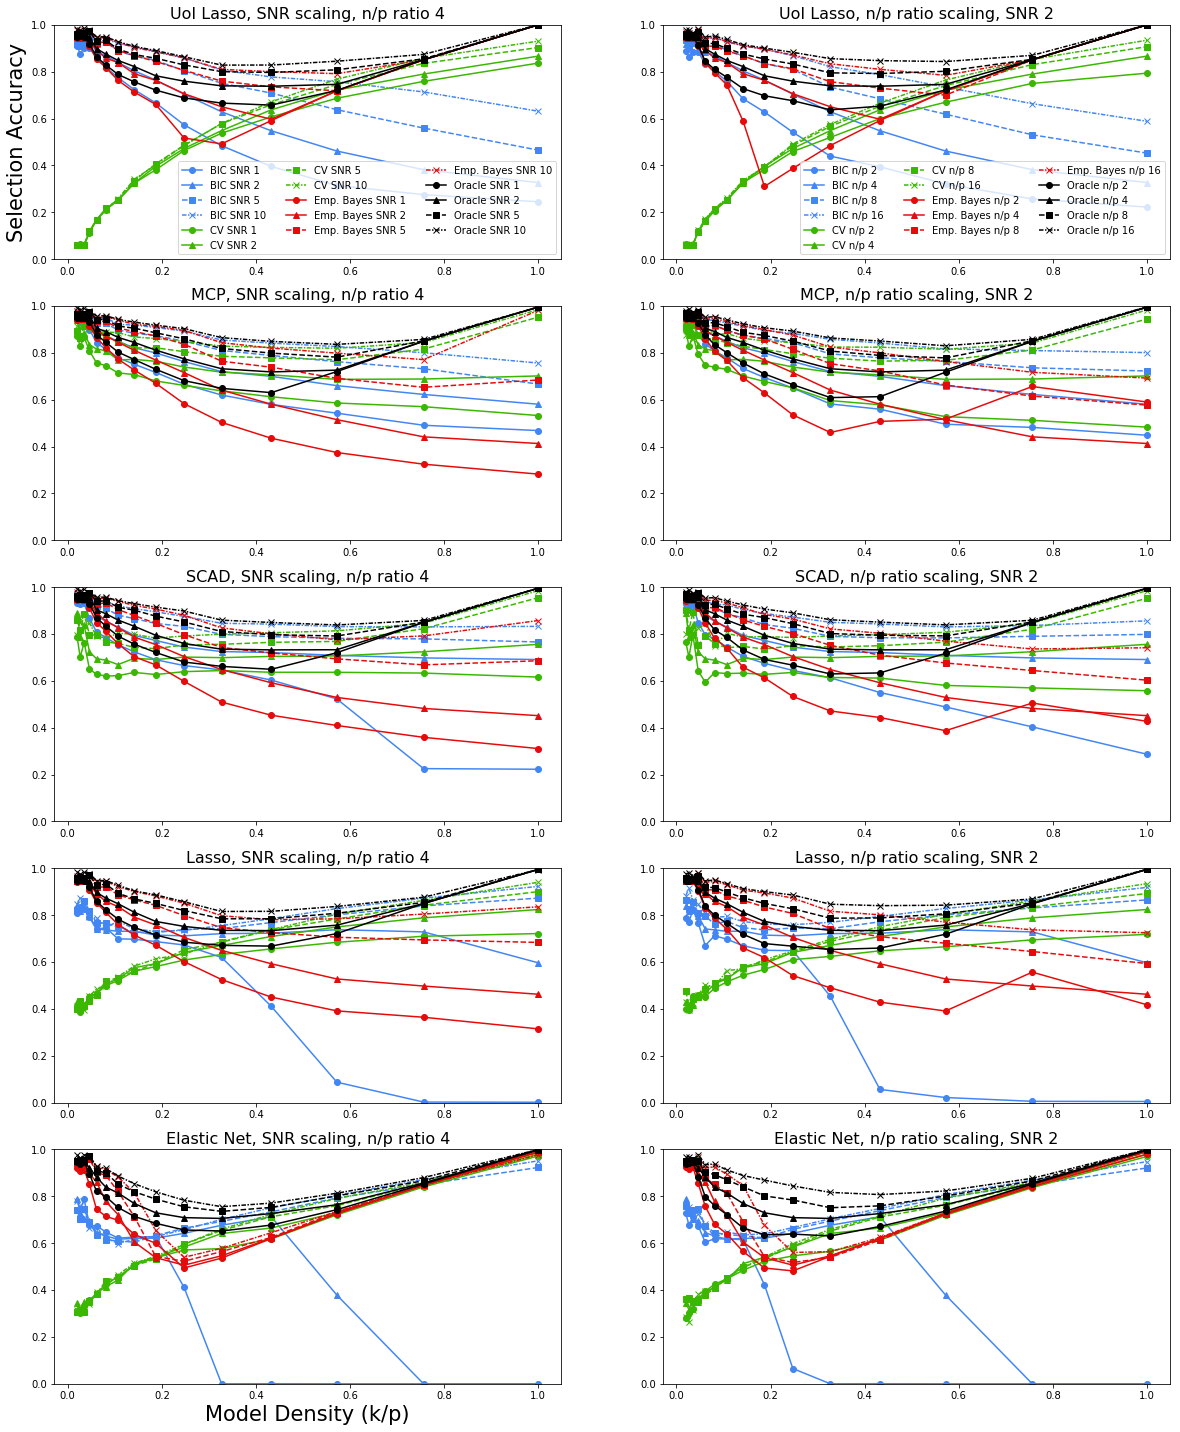

In [14]:
# For 3 different covariance matrices, plot selection accuracy vs sparsity for all algorithms and all selection methods
# Manually selected cov_params
cov_idxs = [27, 38]

# Fix the np_ratio, signal to noise, and betawidth
betawidth = np.inf

sparsity = np.unique(lasso['sparsity'].values)
dframes = [uoi, mcp, scad, lasso, en]
dframe_names = ['UoI Lasso', 'MCP', 'SCAD', 'Lasso', 'Elastic Net']
selection_methods = ['BIC', 'CV', 'empirical_bayes', 'oracle']

# Use the same colors for each algorithm, different line style/marker combinations for each selection method
colors = []

fig, ax = plt.subplots(len(dframes), 2, figsize=(20, 25))
for i1, dframe in enumerate(dframes):
    
    # Noise scaling
    a = ax[i1, 0]
    a.set_title('%s, SNR scaling, n/p ratio 4' % (dframe_names[i1]), fontsize=16)
    for i3, sm in enumerate(selection_methods):
        for i2, k in enumerate(kappa):
            df_ = apply_df_filters(dframe, np_ratio=4, cov_idx=cov_idxs[0], 
                               kappa=k, betawidth = betawidth, selection_method=sm)
            s, yvals, yerr = marginalize(df_, 'sa', ['sparsity'])
            
            # Extract and order
            s = np.array([val for sublist in s for val in sublist])
            yvals = yvals[0]
            yerr = yerr[0]
                        
            sorder = np.argsort(s)
            s = s[sorder]
            yvals = yvals[sorder]
            yerr = yerr[sorder]
            # Organize color by selection method
            # Organize marker/linestyle to denote
            a.plot(s, yvals, marker = pltstyles[i2][1], linestyle = pltstyles[i2][0], color=cols[i3])
            a.set_ylim([0, 1])
            
    # np ratio scaling
    a = ax[i1, 1]
    a.set_title('%s, n/p ratio scaling, SNR 2' % (dframe_names[i1]), fontsize=16)
    for i3, sm in enumerate(selection_methods):
        for i2, npr in enumerate(np_ratios):
            df_ = apply_df_filters(dframe, np_ratio=npr, cov_idx=cov_idxs[0], 
                                   kappa=2, betawidth = betawidth, selection_method=sm)
            s, yvals, yerr = marginalize(df_, 'sa', ['sparsity'])
            # Extract and order
            s = np.array([val for sublist in s for val in sublist])
            yvals = yvals[0]
            yerr = yerr[0]
                        
            sorder = np.argsort(s)
            s = s[sorder]
            yvals = yvals[sorder]
            yerr = yerr[sorder]
            a.plot(s, yvals, marker = pltstyles[i2][1], linestyle = pltstyles[i2][0], color=cols[i3])
            a.set_ylim([0, 1])
            
            
ax[0, 0].set_ylabel('Selection Accuracy', fontsize = 21)
ax[-1, 0].set_xlabel('Model Density (k/p)', fontsize = 21)
ax[0, 0].legend(['BIC SNR 1', 'BIC SNR 2', 'BIC SNR 5', 'BIC SNR 10', 'CV SNR 1', 'CV SNR 2',
              'CV SNR 5', 'CV SNR 10', 'Emp. Bayes SNR 1', 'Emp. Bayes SNR 2', 'Emp. Bayes SNR 5', 'Emp. Bayes SNR 10',
              'Oracle SNR 1', 'Oracle SNR 2', 'Oracle SNR 5', 'Oracle SNR 10'], 
              ncol = 3, loc='lower right')
ax[0, 1].legend(['BIC n/p 2', 'BIC n/p 4', 'BIC n/p 8', 'BIC n/p 16', 'CV n/p 2', 'CV n/p 4',
              'CV n/p 8', 'CV n/p 16', 'Emp. Bayes n/p 2', 'Emp. Bayes n/p 4', 'Emp. Bayes n/p 8', 'Emp. Bayes n/p 16',
              'Oracle n/p 2', 'Oracle n/p 4', 'Oracle n/p 8', 'Oracle n/p 16'], 
              ncol = 3, loc='lower right')

plt.savefig('snr_np_scaling_cov1.pdf', bbox_inches='tight', pad_inches=0)

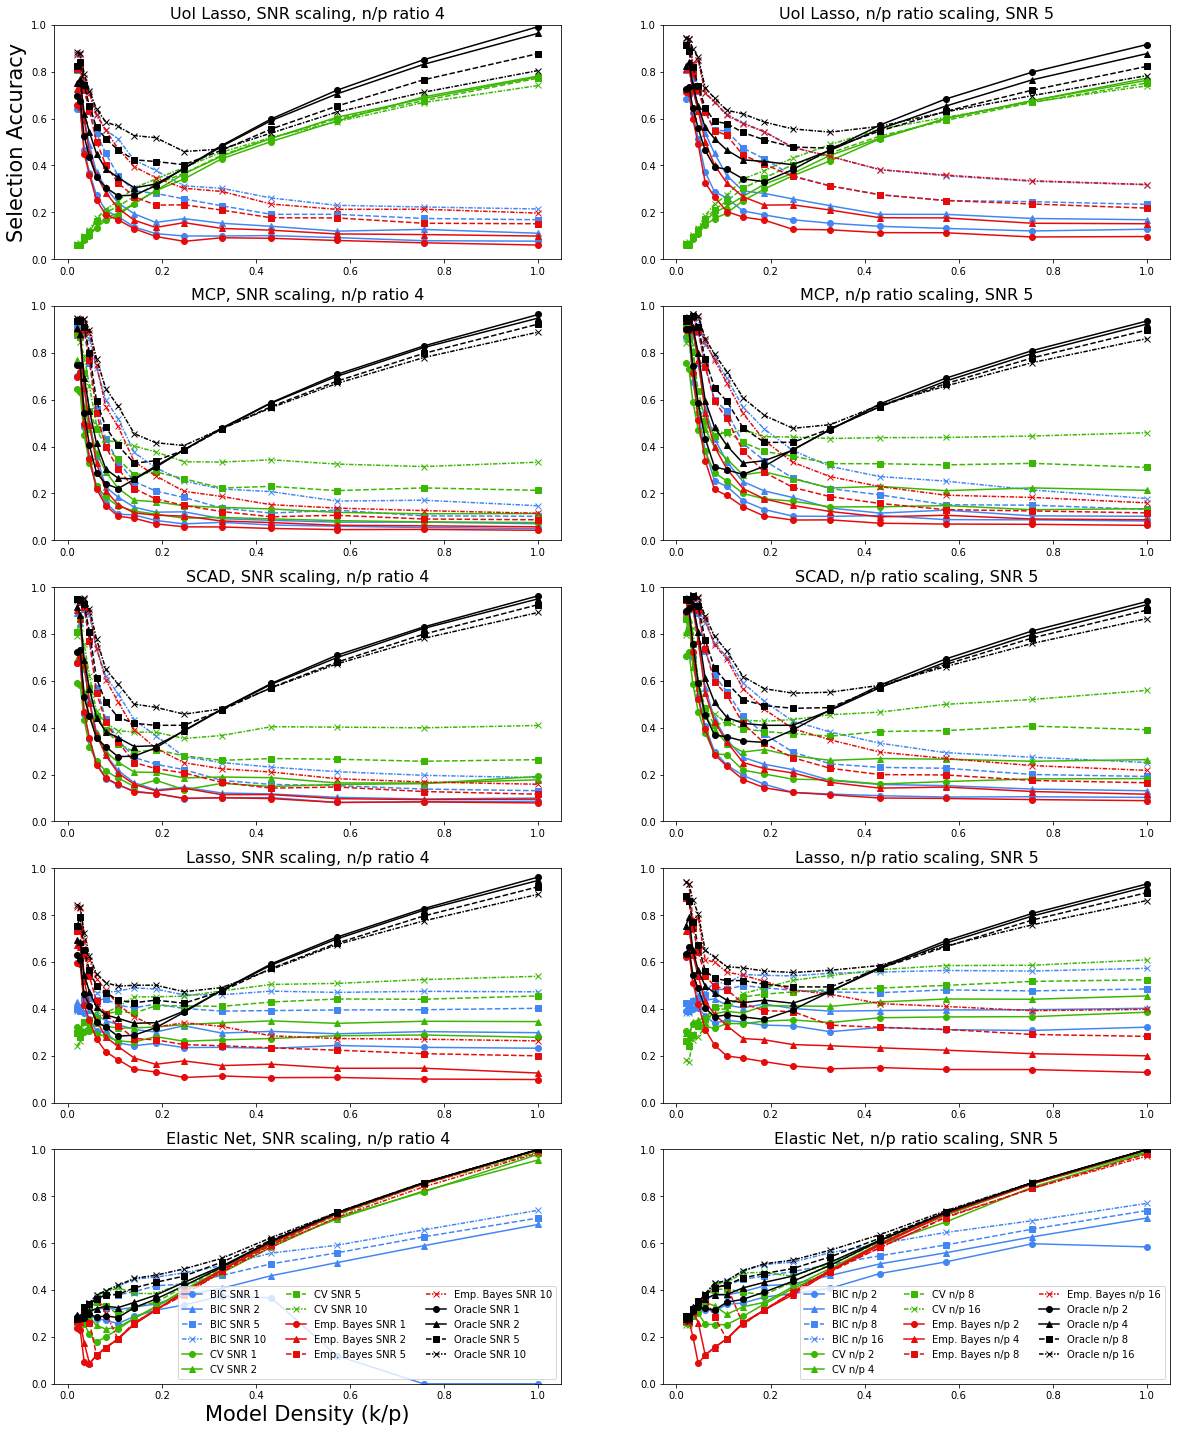

In [15]:
# For 3 different covariance matrices, plot selection accuracy vs sparsity for all algorithms and all selection methods
# Manually selected cov_params
cov_idxs = [27, 38]

# Fix the np_ratio, signal to noise, and betawidth
betawidth = np.inf

sparsity = np.unique(lasso['sparsity'].values)
dframes = [uoi, mcp, scad, lasso, en]
dframe_names = ['UoI Lasso', 'MCP', 'SCAD', 'Lasso', 'Elastic Net']
selection_methods = ['BIC', 'CV', 'empirical_bayes', 'oracle']

# Use the same colors for each algorithm, different line style/marker combinations for each selection method
colors = []

fig, ax = plt.subplots(len(dframes), 2, figsize=(20, 25))
for i1, dframe in enumerate(dframes):
    
    # Noise scaling
    a = ax[i1, 0]
    a.set_title('%s, SNR scaling, n/p ratio 4' % (dframe_names[i1]), fontsize=16)
    for i3, sm in enumerate(selection_methods):
        for i2, k in enumerate(kappa):
            df_ = apply_df_filters(dframe, np_ratio=4, cov_idx=cov_idxs[1], 
                               kappa=k, betawidth = betawidth, selection_method=sm)
            s, yvals, yerr = marginalize(df_, 'sa', ['sparsity'])
            
            # Extract and order
            s = np.array([val for sublist in s for val in sublist])
            yvals = yvals[0]
            yerr = yerr[0]
                        
            sorder = np.argsort(s)
            s = s[sorder]
            yvals = yvals[sorder]
            yerr = yerr[sorder]
            # Organize color by selection method
            # Organize marker/linestyle to denote
            a.plot(s, yvals, marker = pltstyles[i2][1], linestyle = pltstyles[i2][0], color=cols[i3])
            a.set_ylim([0, 1])
            
    # np ratio scaling
    a = ax[i1, 1]
    a.set_title('%s, n/p ratio scaling, SNR 5' % (dframe_names[i1]), fontsize=16)
    for i3, sm in enumerate(selection_methods):
        for i2, npr in enumerate(np_ratios):
            df_ = apply_df_filters(dframe, np_ratio=npr, cov_idx=cov_idxs[1], 
                                   kappa=5, betawidth = betawidth, selection_method=sm)
            s, yvals, yerr = marginalize(df_, 'sa', ['sparsity'])
            # Extract and order
            s = np.array([val for sublist in s for val in sublist])
            yvals = yvals[0]
            yerr = yerr[0]
                        
            sorder = np.argsort(s)
            s = s[sorder]
            yvals = yvals[sorder]
            yerr = yerr[sorder]
            a.plot(s, yvals, marker = pltstyles[i2][1], linestyle = pltstyles[i2][0], color=cols[i3])
            a.set_ylim([0, 1])
            
            
ax[0, 0].set_ylabel('Selection Accuracy', fontsize = 21)
ax[-1, 0].set_xlabel('Model Density (k/p)', fontsize = 21)
ax[-1, 0].legend(['BIC SNR 1', 'BIC SNR 2', 'BIC SNR 5', 'BIC SNR 10', 'CV SNR 1', 'CV SNR 2',
              'CV SNR 5', 'CV SNR 10', 'Emp. Bayes SNR 1', 'Emp. Bayes SNR 2', 'Emp. Bayes SNR 5', 'Emp. Bayes SNR 10',
              'Oracle SNR 1', 'Oracle SNR 2', 'Oracle SNR 5', 'Oracle SNR 10'], 
              ncol = 3, loc='lower right')
ax[-1, 1].legend(['BIC n/p 2', 'BIC n/p 4', 'BIC n/p 8', 'BIC n/p 16', 'CV n/p 2', 'CV n/p 4',
              'CV n/p 8', 'CV n/p 16', 'Emp. Bayes n/p 2', 'Emp. Bayes n/p 4', 'Emp. Bayes n/p 8', 'Emp. Bayes n/p 16',
              'Oracle n/p 2', 'Oracle n/p 4', 'Oracle n/p 8', 'Oracle n/p 16'], 
              ncol = 3, loc='lower right')

plt.savefig('snr_np_scaling_cov2.pdf', bbox_inches='tight', pad_inches=0)